## Hello World in Deep Learning Audio Recognition

### speech recognition

Build a basic speech recognition network that recognizes ten different words.The model tries to classify a one second audio clip as either silence, an unknown word, "yes", "no", "up", "down", "left", "right", "on", "off", "stop", or "go".

#### Imports

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

!pip show tensorflow

!git clone https://github.com/tensorflow/tensorflow.git /content/sample_data/tf



Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorboard, wheel, numpy, gast, astor, opt-einsum, google-pasta, six, keras-preprocessing, termcolor, wrapt, protobuf, grpcio, absl-py, keras-applications, tensorflow-estimator
Required-by: stable-baselines, mesh-tensorflow, magenta, fancyimpute
Cloning into '/content/sample_data/tf'...
remote: Enumerating objects: 743803, done.
remote: Total 743803 (delta 0), reused 0 (delta 0), pack-reused 743803
Receiving objects: 100% (743803/743803), 416.58 MiB | 26.46 MiB/s, done.
Resolving deltas: 100% (600953/600953), done.
Checking out files: 100% (18841/18841), done.


In [0]:
!python /content/sample_data/tf/tensorflow/examples/speech_commands/train.py

2019-10-22 07:47:34.212961: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-10-22 07:47:34.213304: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x319d480 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-10-22 07:47:34.213341: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-10-22 07:47:34.215869: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-22 07:47:34.292118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-10-22 07:47:34.293073: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6c4e300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2019-10-22 07:47:34

In [0]:
!python /freeze.py --start_checkpoint=/tmp/speech_commands_train/conv.ckpt-18000 --output_file=/tmp/final_frozen_graph.pb


In [0]:
!python /freeze.py --start_checkpoint=/tmp/speech_commands_train/conv.ckpt-14700 --output_file=/tmp/14700_frozen_graph.pb


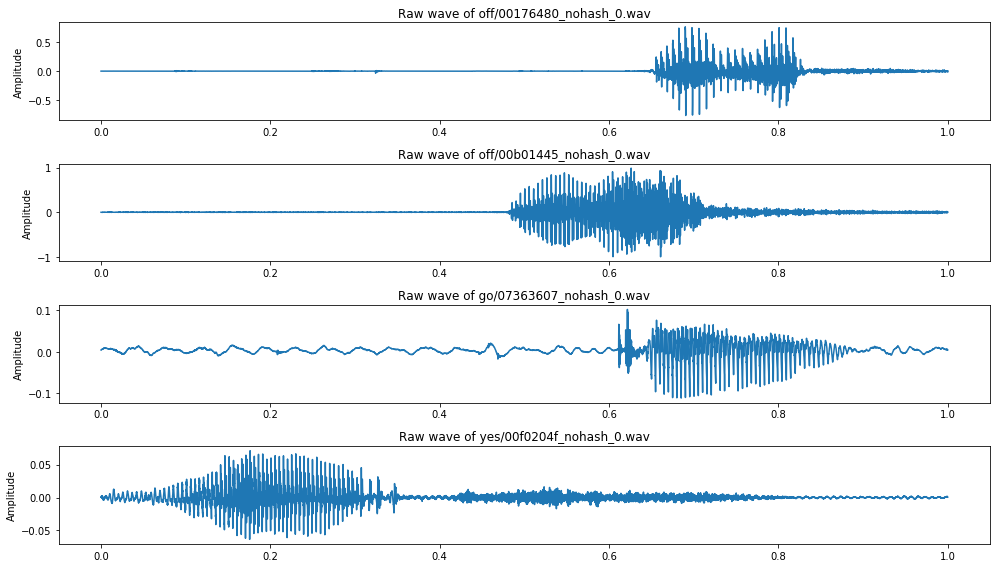

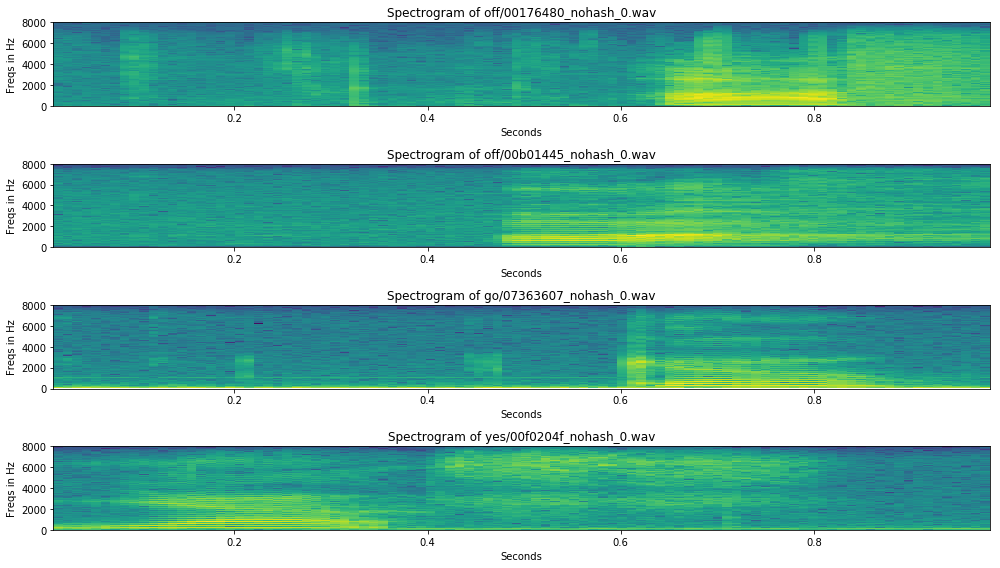

In [0]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
 
DIR = '/tmp/speech_dataset/'
fns = ['off/00176480_nohash_0.wav',
       'off/00b01445_nohash_0.wav',
       'go/07363607_nohash_0.wav',
       'yes/00f0204f_nohash_0.wav']
SAMPLE_RATE = 16000
 
def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    _, wav = wavfile.read(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
 
    ax = fig.add_subplot(4,1,i+1)
    ax.set_title('Raw wave of ' + fn)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, SAMPLE_RATE/len(wav), SAMPLE_RATE), wav)
fig.tight_layout()


from scipy.signal import stft
 
def log_spectrogram(wav):
    freqs, times, spec = stft(wav, SAMPLE_RATE, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
    freqs, times, amp = log_spectrogram(wav)
    
    ax = fig.add_subplot(4,1,i+1)
    ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of ' + fn)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
fig.tight_layout()

In [0]:

import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
 
import dataset as ds
 
DIR = '/tmp/speech_dataset/' # unzipped train and test data
 
INPUT_SHAPE = (177,98,1)
BATCH = 32
EPOCHS = 15
 

LABELS = '_silence_ _unknown_ yes no up down left right on off stop go'.split()
NUM_CLASSES = len(LABELS)